<h1 style="color:dodgerblue"> 
ISEF 2024-25 Project
</h1>

<h3 style="color:white"> 
Quantum Error Correction Codes: Accuracy vs Time Complexity
</h3>

##### <span style="color: white;"> By: Sumer Chaudhary, 9th Grade, BASIS Independent McLean
###### <span style="color: white;"> sumerchaudhary1@gmail.com

______________________
<h6 style="color:dodgerblue"> 
12/15/2024 - 
</h6>

## <span style="color: white;">Imports and Setup

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager, transpile
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.quantum_info import Statevector, Operator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import IfElseOp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2
from control import create_bell_state
from shor import create_shor_bell_state
from steane import create_steane_bell_state
from fqc import create_fqc_bell_state

service=QiskitRuntimeService(channel="ibm_quantum")

In [2]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

qBackend = service.least_busy(simulator=False)

noise_model = NoiseModel.from_backend(qBackend)
simBackend = AerSimulator(noise_model=noise_model, method="matrix_product_state")

## <span style="color: white;">Creating Circuits

### <span style="color: white;"> Control Group

In [3]:
control_qc = create_bell_state()

#control_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/control.png")

### <span style="color: white;"> Shor's Error Correction Code

In [4]:
shor_qc = create_shor_bell_state()

#shor_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=True, filename="Diagrams/shor.png")

### <span style="color: white;"> Steane Error Correction Code

In [5]:
steane_qc = create_steane_bell_state()

#steane_qc.draw("mpl", style="clifford", scale=0.75, fold=-1, plot_barriers=True, initial_state=True, justify="none", filename="Diagrams/steane.png")

### <span style="color: white;"> Five Qubit Error Correction Code

In [6]:
fqc_qc = create_fqc_bell_state()

#fqc_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=True, justify="none", filename="Diagrams/five_qubit_code.png")

## <span style="color: white;">    Running experiments

### <span style="color: white;">Simulator

In [7]:
# Convert to an ISA circuit (circuit mapped to the backend's Information Set Architecture),
# and layout-mapped observables.
circuits = [control_qc, shor_qc, steane_qc, fqc_qc]
pm = generate_preset_pass_manager(backend=simBackend, optimization_level=3)
isa_circuits = [pm.run(circuit) for circuit in circuits]

In [8]:
#Run the ISA circuits
numShots = 250
jobs = [simBackend.run(circuit, shots=numShots) for circuit in isa_circuits]

In [9]:
results = []
time = []
for job in jobs:
    proc_results = {'00': 0, '01': 0, '10': 0, '11': 0}
    proc_time = {circuits[jobs.index(job)].name: job.result().time_taken}
    for res in job.result().get_counts(0):
        proc_results[res[:2]] += job.result().get_counts(0)[res]
    results.append(proc_results)
    time.append(proc_time)

print(results, "\n", time)

[{'00': 107, '01': 8, '10': 12, '11': 123}, {'00': 61, '01': 62, '10': 47, '11': 80}, {'00': 80, '01': 52, '10': 52, '11': 66}, {'00': 101, '01': 27, '10': 24, '11': 98}] 
 [{'Bell State Unencoded': 0.7096672058105469}, {"Bell State Encoded with Shor's Code": 401.93678522109985}, {"Bell State Encoded with Steane's Code": 252.62819480895996}, {'Bell State Encoded with the Five Qubit Code': 5.963917016983032}]


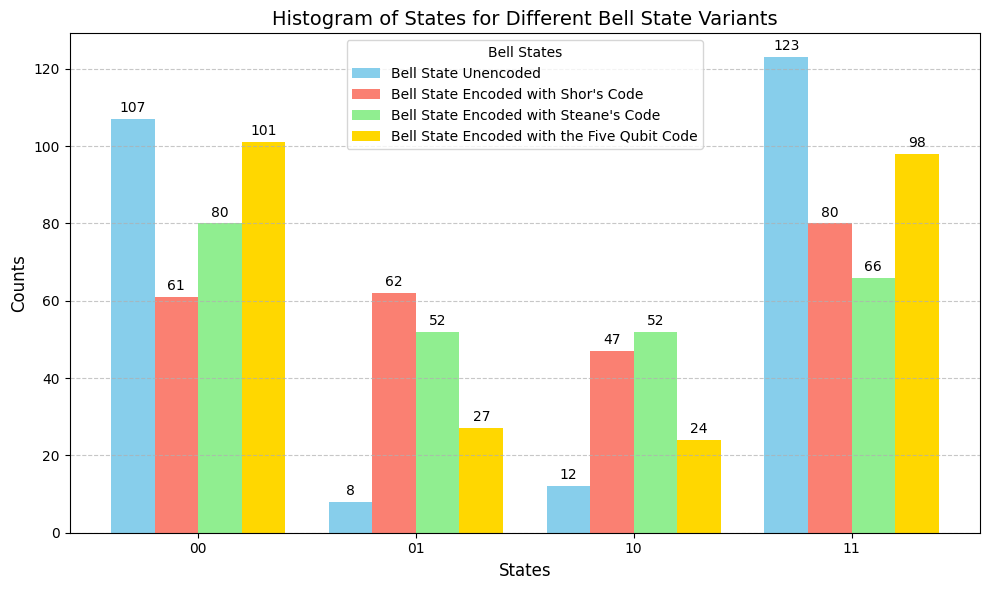

In [40]:
states = {}
for result in results:
    states[circuits[results.index(result)].name] = result
# Extract data
categories = list(next(iter(states.values())).keys())  # ['00', '01', '10', '11']
bar_width = 0.2  # Width of each bar
x = np.arange(len(categories))  # X positions for bars

# Define colors for each dataset
colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
names = list(states.keys())  # Names of the datasets

# Plot the histogram
plt.figure(figsize=(10, 6))
for i, (name, counts) in enumerate(states.items()):
    counts_values = [counts[category] for category in categories]
    bar_positions = x + i * bar_width
    bars = plt.bar(bar_positions, counts_values, width=bar_width, label=name, color=colors[i])
    
    # Add text annotations above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 1,  # Slightly above the bar
            f'{int(height)}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )


# Add labels, title, and legend
plt.xlabel('States', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of States for Different Bell State Variants', fontsize=14)
plt.xticks(x + bar_width * (len(states) - 1) / 2, categories, fontsize=10)  # Adjust x-ticks
plt.legend(title='Bell States', fontsize=10)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('Results/all.png')
plt.show()

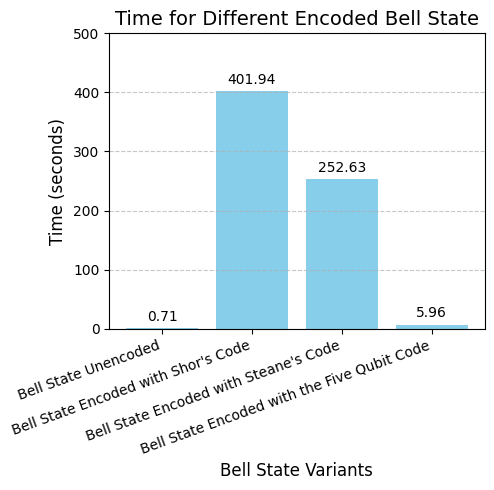

In [47]:
names = [list(item.keys())[0] for item in time]
times = [list(item.values())[0] for item in time]

# Plot the bar chart
plt.figure(figsize=(5, 5))  # Adjust size as needed
bars = plt.bar(names, times, color='skyblue')
plt.ylim(0, 500)  # Set max y-value to 500

# Add value annotations above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + max(times) * 0.02,  # Slightly above the bar
        f'{height:.2f}',  # Format the time with 2 decimal places
        ha='center', 
        va='bottom', 
        fontsize=10
    )

plt.ylim(0, 500)  # Set max y-value to 500

# Add labels and title
plt.xlabel('Bell State Variants', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time for Different Encoded Bell State', fontsize=14)
plt.xticks(rotation=20, ha='right', fontsize=10)  # Rotate labels for readability

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('Results/time.png')
plt.show()
plt.close()


### <span style="color: white;"> Quantum Computer

In [7]:
# Convert to an ISA circuit and layout-mapped observables.
circuits = [control_qc, shor_qc, steane_qc, fqc_qc]
pm = generate_preset_pass_manager(backend=qBackend, optimization_level=3)
control_isa_circuit = pm.run(control_qc)
shor_isa_circuit = pm.run(shor_qc)
steane_isa_circuit = pm.run(steane_qc)
fqc_isa_circuit = pm.run(fqc_qc)

In [8]:
# Create a batch of jobs
with Batch(backend=qBackend):
    sampler = SamplerV2()
    
    #Run each circuit (maximum of three pending jobs, so I can only run these three, and then run the Five Qubit Code (I'm also running the Steane code after because debugging stuff)
    control_job = sampler.run(pubs=[control_isa_circuit], shots=1024)
    shor_job = sampler.run(pubs=[shor_isa_circuit], shots=1024)
    steane_job = sampler.run(pubs=[steane_isa_circuit], shots=1024)


print(f">>> Control Job ID: {control_job.job_id()}")
print(f">>> Shor Job ID: {shor_job.job_id()}")
print(f">>> Steane Job ID: {steane_job.job_id()}")

>>> Control Job ID: cy1jmzv6vek0008rame0
>>> Shor Job ID: cy1jn0m9b62g008h6rj0
>>> Steane Job ID: cy1jn0w9b62g008h6rjg


In [9]:
#Get the results
control_result = control_job.result()
shor_result = shor_job.result()
steane_result = steane_job.result()

In [11]:
#print(steane_job.metrics()["usage"]["quantum_seconds"])
plot_histogram(control_result[0].data.measured_output.get_counts(), filename="FinalResults/control.png")
plot_histogram(shor_result[0].data.measured_output.get_counts(), filename="FinalResults/shor.png")
plot_histogram(steane_result[0].data.measured_output.get_counts(), filename="FinalResults/steane.png")

In [12]:
sampler = SamplerV2(mode=qBackend)
#Run the other two jobs
fqc_job = sampler.run(pubs=[fqc_isa_circuit], shots=1024)

print(f">>> Five Qubit Code Job ID: {fqc_job.job_id()}")

>>> Five Qubit Code Job ID: cy1jpj2nrmz000854r8g


In [13]:
fqc_result = fqc_job.result()

In [14]:
plot_histogram(fqc_result[0].data.measured_output.get_counts(), filename="FinalResults/fqc.png")

In [15]:
jobs=[control_job, shor_job, steane_job, fqc_job]

In [17]:
results = []
time = []

for job in jobs:
    proc_results = {'00': 0, '01': 0, '10': 0, '11': 0}
    proc_time = {circuits[jobs.index(job)].name: job.metrics()["usage"]["quantum_seconds"]}
    for res in job.result()[0].data.measured_output.get_counts():
        proc_results[res[:2]] += job.result()[0].data.measured_output.get_counts()[res]
    results.append(proc_results)
    time.append(proc_time)

print(results, "\n", time)

[{'00': 504, '01': 10, '10': 4, '11': 506}, {'00': 294, '01': 218, '10': 285, '11': 227}, {'00': 272, '01': 254, '10': 258, '11': 240}, {'00': 268, '01': 268, '10': 252, '11': 236}] 
 [{'Bell State Unencoded': 2}, {"Bell State Encoded with Shor's Code": 2}, {"Bell State Encoded with Steane's Code": 3}, {'Bell State Encoded with the Five Qubit Code': 2}]


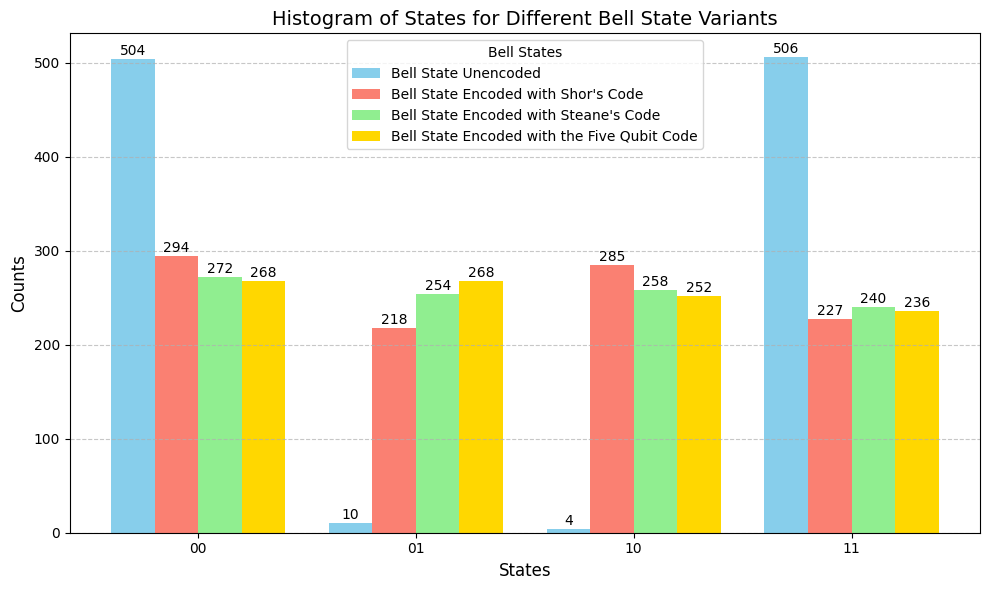

In [18]:
states = {}
for result in results:
    states[circuits[results.index(result)].name] = result
# Extract data
categories = list(next(iter(states.values())).keys())  # ['00', '01', '10', '11']
bar_width = 0.2  # Width of each bar
x = np.arange(len(categories))  # X positions for bars

# Define colors for each dataset
colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
names = list(states.keys())  # Names of the datasets

# Plot the histogram
plt.figure(figsize=(10, 6))
for i, (name, counts) in enumerate(states.items()):
    counts_values = [counts[category] for category in categories]
    bar_positions = x + i * bar_width
    bars = plt.bar(bar_positions, counts_values, width=bar_width, label=name, color=colors[i])
    
    # Add text annotations above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 1,  # Slightly above the bar
            f'{int(height)}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )


# Add labels, title, and legend
plt.xlabel('States', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of States for Different Bell State Variants', fontsize=14)
plt.xticks(x + bar_width * (len(states) - 1) / 2, categories, fontsize=10)  # Adjust x-ticks
plt.legend(title='Bell States', fontsize=10)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('FinalResults/all.png')
plt.show()

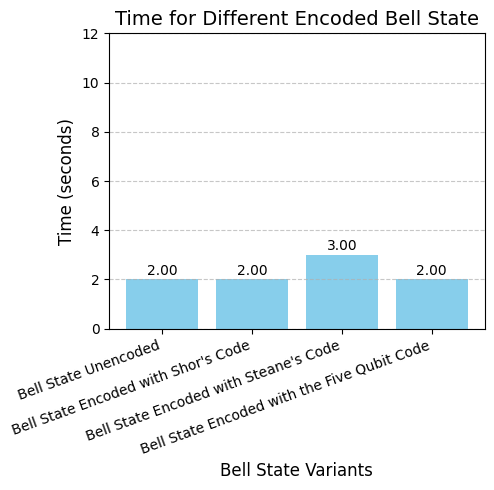

In [19]:
names = [list(item.keys())[0] for item in time]
times = [list(item.values())[0] for item in time]

# Plot the bar chart
plt.figure(figsize=(5, 5))  # Adjust size as needed
bars = plt.bar(names, times, color='skyblue')
plt.ylim(0, 12)  # Set max y-value to 500

# Add value annotations above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + max(times) * 0.02,  # Slightly above the bar
        f'{height:.2f}',  # Format the time with 2 decimal places
        ha='center', 
        va='bottom', 
        fontsize=10
    )

# Add labels and title
plt.xlabel('Bell State Variants', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time for Different Encoded Bell State', fontsize=14)
plt.xticks(rotation=20, ha='right', fontsize=10)  # Rotate labels for readability

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('FinalResults/time.png')
plt.show()
plt.close()